# Off-Chain Clustering
In this notebook, we detail how we cluster LN nodes based on their alias, ASN and IP address. The sections are:
1. Data
2. Example node alias/ASN clustering with LNBIG nodes
3. Evaluate a range of distance measures
4. Rerun clustering with best measure and threshold parameter
5. Perform IP-based clustering
6. Merge alias/ASN clusters with IP-based clusters

In [17]:
import sys
sys.path.append("..")

from utils import get_same_asn_clusters, evaluate_single_result, evaluate_measure

# input files
from utils import nodes_csv_file, ips_csv_file, whois_csv_file, \
    alias_address_clusters_csv_file,

# output files
from utils import alias_address_clusters_csv_file

from jellyfish import levenshtein_distance, damerau_levenshtein_distance, \
    hamming_distance
from matplotlib import rcParams
import scipy
import pandas as pd
import numpy as np
from tqdm import tqdm  # progress bars
import networkx as nx
import matplotlib.pyplot as plt
from plotnine import theme_bw, theme, element_text, ggplot, geom_bar, aes, \
    geom_text, labs
from utils import relative_lcs, cluster, lcs_distance, \
    relative_levenshtein, relative_damerau_levenshtein, relative_hamming, \
    jaro_distance, jaro_winkler_distance, is_reserved_address

theme_publication = theme_bw() + theme(text=element_text(family="cmr10", size=12, color="black"), \
                                       axis_title=element_text(size=14))

# 1. Data
In this section, we fetch and prepare node aliases, node IPs and retrieve WHOIS data

#### Inputs (made available):
- `nodes_csv_file`
- `ip_address_csv_file`
- `whois_csv_file` (optional)

#### Outputs (made available):
- `alias_address_clusters_csv_file`

You can either run all the cells (some might take several hours to complete, look for the \*\*WARNING** comment in the cells) or run directly the "output files" cell and have a look at the data.

In [33]:
# input files
node_aliases = pd.read_csv(nodes_csv_file)
node_ips = pd.read_csv(ips_csv_file)
whois_data = pd.read_csv(whois_csv_file) # optional, can also be retrieved from node_ips

In [34]:
# output files (the set of nodes that have been clustered by the process in this notebook)
final_clusters = pd.read_csv(alias_address_clusters_csv_file)

In [2]:
# Prepare node aliases
# have each pub_key / alias combination in a separate row
node_aliases.alias = node_aliases.alias.apply(lambda x: x.split("|"))
node_aliases = node_aliases.explode("alias")
# filter to remove empty aliases
node_aliases = node_aliases[node_aliases.alias.str.len() > 0].copy()
print("Got", len(node_aliases), "aliases")

Got 9724 aliases


In [3]:
# Process IP addresses
# have each pub_key / ip combination in a separate row
node_ips.ip_address = node_ips.ip_address.apply(lambda x: x.split("|"))
node_ips = node_ips.explode("ip_address")
# separate port and ip address for easier querying
node_ips['port'] = node_ips.ip_address.apply(lambda x: x.rsplit(":", 1)[1])
node_ips['ip_address'] = node_ips.ip_address.apply(lambda x: x.rsplit(":", 1)[0].strip("[]"))

# FILTER (remove addresses that don't make sense)
# https://en.wikipedia.org/wiki/Reserved_IP_addresses

reserved_ips = node_ips.ip_address.apply(is_reserved_address)
print("Removing a total of:", sum(reserved_ips), "reserved IPs")
node_ips = node_ips[~reserved_ips]

Removing a total of: 393 reserved IPs


In [4]:
# Retrieve whois data
# **WARNING**, this may take several hours

try:
    whois_data = pd.read_csv(whois_csv_file)
    whois_data = whois_data[~whois_data.entities.isna()]
except:
    print("No existing whois data, querying all IP addresses now")
    from ipwhois import IPWhois

    def lookup(ip_address):
        fail = {"query": ip_address}
        if ".onion" in ip_address:
            return fail
        else:
            try:
                res = IPWhois(ip_address).lookup_rdap(depth=1)
                return res
            except:
                print(ip_address, "couldn't be queried...")
                return fail
    whois_jsons = [lookup(ip_address) for ip_address in tqdm(node_ips.ip_address.unique())]
    whois_data = pd.DataFrame(whois_jsons)
    # whois_data = pd.DataFrame.from_dict(whois_jsons) # tofix
    whois_data.to_csv(whois_csv_file, index=False)

# only keep asn and ip_address
whois_data = whois_data[["asn", "query"]].rename(columns={"query": "ip_address"})

# 2. Example alias/ASN node clustering with LNBIG nodes
To illustrate how the clustering works, we select only a small subset of lightning nodes, specifically those containing the term "LNBIG", some "Lightning" and some random ones.
We then cluster those nodes with the relative longest common substring method and plot a dendrogram

In [5]:
# Select a temporary subset of aliases containing LNBIG nodes
tmp_aliases = node_aliases[node_aliases.alias.str.contains("LNBIG")]
# add random "Lightning" aliases
tmp_aliases = tmp_aliases.append(
    node_aliases[node_aliases.alias.str.contains("Lightning")].sample(10, random_state=7))
# add entirely random aliases
tmp_aliases = tmp_aliases.append(node_aliases.sample(
    10, random_state=7)).drop_duplicates().reset_index(drop=True)

distance_measure = relative_lcs
# define that the common substring needs to account for 54% of all letters of the longer string
max_distance_threshold = 1 - 0.54 # = 0.46

clusters, Z = cluster(tmp_aliases, distance_measure, max_distance_threshold)

<ipython-input-6-c0ca5f6b486a>:9: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later


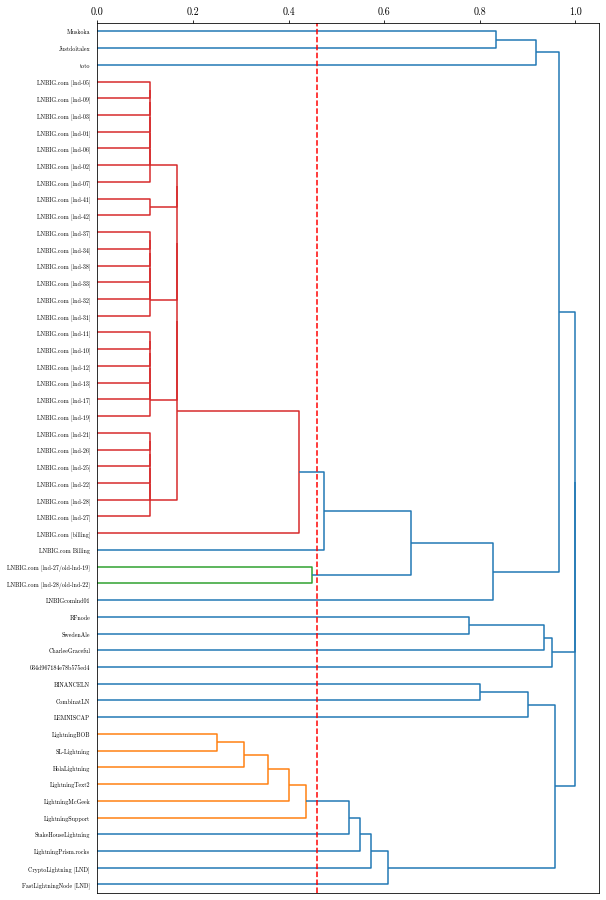

In [6]:
# plot dendrogram (only makes sense for small data like this subset...)
rcParams['font.family'] = 'cmr10'
fig = plt.figure(figsize=(9, 16))
ax = fig.add_subplot(1, 1, 1)
dn = scipy.cluster.hierarchy.dendrogram(
    Z, orientation="right", labels=clusters.alias.values, color_threshold=max_distance_threshold)
ax.axvline(x=max_distance_threshold, color='r', ls="--")
ax.xaxis.set_ticks_position("top")
plt.savefig("alias_dendrogram_example.pdf", papertype="letter", bbox_inches="tight")

# 3. Evaluate a range of distance measures
Here we perform a systematic evaluation of distance measures with parameter ranges.
All results are concatenated, and the following statistics are computed:
- number of nodes clustered
- cluster count
- cluster count with least 3 nodes
- cluster count with at least 26 nodes

We know from online evidence, that the LNBig cluster contains at least 26 nodes and the lnd-gar-nodl-it cluster is even larger, that is why the last metric is of interest. If no such large clusters are found, the distance measure and parameter combination is not useful.

In [8]:
%%time
# evaluate all measures with parameter ranges
# **WARNING**, this may take several hours, as the distance computation is of quadratic complexity
tmp_aliases = node_aliases.copy()
results = pd.concat([
    evaluate_measure(tmp_aliases, node_ips, whois_data, relative_lcs, np.arange(0, 1, 0.01)),
    evaluate_measure(tmp_aliases, node_ips, whois_data, lcs_distance, 1/np.arange(1, 15, 1)),
    evaluate_measure(tmp_aliases, node_ips, whois_data, levenshtein_distance, np.arange(0, 10, 1)),
    evaluate_measure(tmp_aliases, node_ips, whois_data, relative_levenshtein, np.arange(0, 1, 0.01)),
    evaluate_measure(tmp_aliases, node_ips, whois_data, damerau_levenshtein_distance, np.arange(0, 10, 1)),
    evaluate_measure(tmp_aliases, node_ips, whois_data, relative_damerau_levenshtein, np.arange(0, 1, 0.01)),
    evaluate_measure(tmp_aliases, node_ips, whois_data, hamming_distance, np.arange(0, 10, 1)),
    evaluate_measure(tmp_aliases, node_ips, whois_data, relative_hamming, np.arange(0, 1, 0.01)),
    evaluate_measure(tmp_aliases, node_ips, whois_data, jaro_distance, np.arange(0, 1, 0.01)),
    evaluate_measure(tmp_aliases, node_ips, whois_data, jaro_winkler_distance, np.arange(0, 1, 0.01))
])

Finished relative_lcs
Finished lcs_distance
Finished levenshtein_distance
Finished relative_levenshtein
Finished damerau_levenshtein_distance
Finished relative_damerau_levenshtein
Finished hamming_distance
Finished relative_hamming
Finished jaro_distance
Finished jaro_winkler_distance
CPU times: user 3h 14min 35s, sys: 39.8 s, total: 3h 15min 14s
Wall time: 3h 15min 25s


In [31]:
# Print the distance measure that at least 2 large clusters (LNBig and lnd-gar-nodl-it),
# and sort by most nodes clustered
results[results.cluster_count_min26 >= 2].sort_values("node_count", ascending=False).dropna().head()

,measure,threshold,node_count,cluster_count,cluster_count_min3,cluster_count_min26
46,relative lcs,0.46,363,126,17,2
48,relative lcs,0.48,361,125,17,2
49,relative lcs,0.49,361,125,17,2
47,relative lcs,0.47,359,124,17,2
53,relative lcs,0.53,355,122,19,2


/home/everything/applications/anaconda3/envs/lightningpaper/lib/python3.9/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 5 x 5 in image.
/home/everything/applications/anaconda3/envs/lightningpaper/lib/python3.9/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: alias_clustering_white.pdf


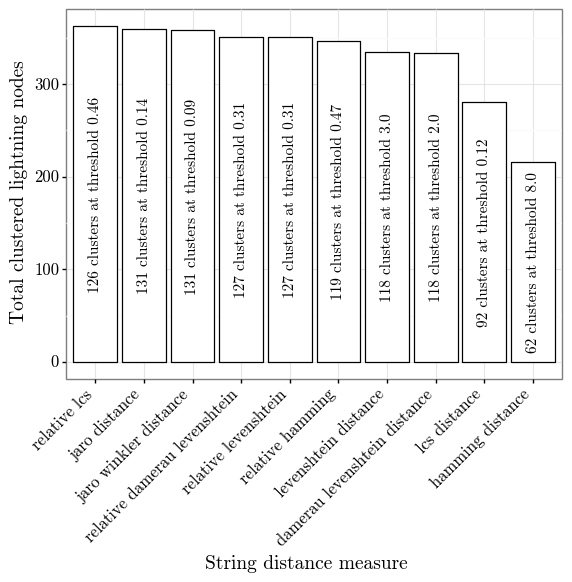

<ggplot: (8744814679881)>

In [22]:
# plot method comparison
bestMeasure_for_plot = results[results.groupby(['measure'])['cluster_count_min26'].transform(
    max) == results['cluster_count_min26']].reset_index(drop=True)
bestMeasure_for_plot = bestMeasure_for_plot.iloc[bestMeasure_for_plot.reset_index().groupby(["measure"])[
    'node_count'].idxmax()]

bestMeasure_for_plot = bestMeasure_for_plot.sort_values("node_count", ascending=False)
measure_list = bestMeasure_for_plot['measure'].values.tolist()
measure_cat = pd.Categorical(bestMeasure_for_plot['measure'], categories=measure_list)
bestMeasure_for_plot = bestMeasure_for_plot.assign(measure_cat=measure_cat)
bestMeasure_for_plot["label_pos"] = bestMeasure_for_plot["node_count"]/2
bestMeasure_for_plot["label_text"] = bestMeasure_for_plot.apply(
    lambda x: str(x["cluster_count"]) + " clusters at threshold "+str(round(x['threshold'], 2)), axis=1)

plot = ggplot(bestMeasure_for_plot) +\
    geom_bar(aes(x="measure_cat", y="node_count"), stat="identity", colour="black", fill="white") +\
    geom_text(aes(x="measure_cat", y="label_pos", label="label_text"), angle=90, colour="black") +\
    labs(x="String distance measure", y="Total clustered lightning nodes") +\
    theme_publication +\
    theme(axis_text_x=element_text(rotation=45, vjust=1, hjust=1))

plot.save("alias_clustering_white.pdf", width=5, height=5)
plot

In [11]:
# print summary of best method:
best = results[results.groupby(['measure'])['cluster_count_min26'].transform(
    max) == results['cluster_count_min26']].reset_index(drop=True)
best = best[best["node_count"] == best["node_count"].max()].iloc[0]
print(best)

measure                relative lcs
threshold                      0.46
node_count                      363
cluster_count                   126
cluster_count_min3               17
cluster_count_min26               2
Name: 3, dtype: object


# 4. Rerun clustering with best measure and threshold parameter
Now that we have identified the best measure and threshold parameter, we run and obtain an alias/ASN clustering

In [32]:
# **WARNING**, this may take about half an hour
final_alias_cluster, _ = cluster(
    node_aliases, globals()[best.measure.replace(" ", "_")], best.threshold)
alias_asn_clusters = get_same_asn_clusters(final_alias_cluster, node_ips, whois_data)[
    ["pub_key", "cluster"]].drop_duplicates()
alias_asn_clusters["cluster_origin"] = "alias/asn"
alias_asn_clusters.head()

,pub_key,cluster,cluster_origin
12169,03b7e9a5827b65a71a03b46e8d38d28410d48ebbc1fc6b...,653,alias/asn
14215,03fbdfe29e107cb685c34dbe000b39a5c029a1ae88f8a4...,653,alias/asn
14224,03fc3d6064a7f6fa6008dd2c13036e9a13427acd2c18fe...,653,alias/asn
10275,0362475f2ecf2f4cd9deb1bd6f0474ac7b133b7baebce8...,653,alias/asn
14814,020bc0a7457d71b9e038a916de479819151a4b152ab548...,653,alias/asn


# 5. Perform IP-based clustering
Here we perform IP and onion address-based clustering

In [13]:
print("Clustering based on same IP/onion address")
same_ip_nodes = node_ips.drop(columns=['port']) \
    .groupby('ip_address') \
    .filter(lambda x: x['pub_key'].nunique() > 1) \
    .sort_values('ip_address')
same_ip_nodes = same_ip_nodes.rename(columns={"ip_address": "cluster"})
same_ip_nodes["cluster_origin"] = "address"
same_ip_nodes.head()

Clustering based on same IP/onion address


,pub_key,cluster,cluster_origin
1184,0268b84ff41b75477349c1b1a8ab77213294884f781602...,104.198.96.115,address
1491,02868e12f320073cad0c2959c42559fbcfd1aa326fcb94...,104.198.96.115,address
438,02251c2b931203848152b1c52e63ee91c74f53b0bfa8dd...,104.248.136.82,address
3536,034653a43cb5857d6f75ff19866e27a8e03355827bf603...,104.248.136.82,address
621,0235591b82c3856e6ccfc10b70b7ccdce45c30994500c8...,104.27.161.98,address


# 6. Merge alias/ASN clusters with IP-based clusters
Now both alias/ASN clusters and IP-based clusters are available, we merge them to obtain the final result, save the alias clustering and produce some summary statistics.

In [25]:
combined = pd.concat([alias_asn_clusters, same_ip_nodes])
G = nx.from_pandas_edgelist(combined, source="pub_key", target="cluster", create_using=nx.DiGraph)
l = list(nx.weakly_connected_components(G))
L = [dict.fromkeys(y, x) for x, y in enumerate(l)]
d = {k: v for d in L for k, v in d.items()}
mapping = pd.DataFrame(list(d.items()), columns=['pub_key', 'newcluster'])
mapping = mapping.merge(combined, how="left", on="pub_key").drop(columns="cluster").dropna()
mapping = mapping.groupby(["newcluster", "pub_key"])["cluster_origin"].agg(
    lambda x: ' & '.join(set(x))).reset_index()
mapping = mapping.merge(node_aliases, how="left")

final_clusters = mapping.groupby(["newcluster", "pub_key", "cluster_origin"])[
    "alias"].agg(lambda x: ' | '.join(set(x.dropna()))).reset_index()
final_clusters = final_clusters.rename(columns={"newcluster": "cluster"})

# write alias clusters to csv file in results folder
final_clusters.to_csv(alias_address_clusters_csv_file, index=False)

In [29]:
cluster_origin_distribution = final_clusters.groupby("cluster_origin")["pub_key"].count()
print("Best clustering algorithm:\n", cluster_origin_distribution, "\n\n")
print("Total nodes clustered: ", final_clusters["pub_key"].count())
print("Total cluster count:", final_clusters.cluster.nunique())

Best clustering algorithm:
 cluster_origin
address                894
alias/asn              116
alias/asn & address    241
Name: pub_key, dtype: int64 


Total nodes clustered:  1251
Total cluster count: 301
